# 预测SP500指数走势

## 一、前言
- 作者：Griddb
- 标题：Modelling S&P 500 Index Price Based on U.S. Economic Indicators using Python and GridDB
- 目的：**利用机器学习中的Regression Model 基于美国经济指标预测SP500走势**
- 原文地址：https://griddb.net/en/blog/modelling-sp-500-index-price-based-on-u-s-economic-indicators-using-python-and-griddb/
- 源码地址：无
- 数据源： `finance.yahoo.com` and `fred.stlouisfed.org`

**声明**
- 本文只是出于学习的目的将其翻译成中文并附上一定的注释，并没有打算将其用作盈利的目的。
- 原文并没有提供原始数据集，我通过作者提供的数据出处，收集数据并清洗后放在文件夹中
- 由于yahoo finance上获取的SP500 index数据只有1985年打后的，所以跟原文的数据有一点出入
- 这里没有使用GridDB数据库，而是直接通过csv格式读取数据
- 数据集的获取方式放到文章的最后

## 二、研究目的
经济指标已被用于许多的研究当中，而且很多的统计方法都结合了这些数据用于预测股票价格。本文的目的是根据美国经济指标对标准普尔500指数的月度价格进行建模， 然后执行统计测试，最后构建机器学习模型。

## 三、数据指标处理
对于SP500指数来说，对其影响最大的指标可归纳为以下类别：一般宏观经济指标，劳动力市场指标（失业率和就业报告），房地产指标，信贷市场指标，货币供应指标，消费者（家庭）金融行为指标和商品市场指标。
- 数据周期为 1985-01-01 至 2022-06-01 之间
- SP500指数收盘价和美国经济指标数据频率均为月度

数据集各变量（指标）的描述：

- 标准普尔500指数各月价格（单位：美元）`SP500`
- 利率，美国贴现率（单位：每年百分比）`INTDSRUSM193N`
- 商业和工业贷款，所有商业银行（单位：数十亿美元）`BUSLOANS`
- 银行优惠贷款利率（单位：百分比）`MPRIME`
- 联邦基金有效利率（联邦基金利率是存款机构隔夜交易联邦资金的利率。（单位：百分比）`FEDFUNDS`
- 流通中的货币（单位：数十亿美元）`CURRCIR`
- 个人储蓄率（个人储蓄占个人可支配收入（DPI）的百分比，通常称为“个人储蓄率”，计算为个人储蓄与DPI的比率。（单位：百分比）`PSAVERT`
- 在许可证发放地点授权的新私人住房单位：总单位（单位：数十亿美元）`PERMIT`
- 工业生产：总指数（工业生产指数（INDPRO）是衡量位于美国制造业，采矿业，电力和天然气公用事业的所有设施的实际产出的经济指标）（单位：指数2017 = 100）`INDPRO`
- 个人储蓄（单位：数十亿美元）`PMSAVE`
- 机动车零售：国内汽车 （单位：百万辆）`DAUTOSAAR`
- 失业水平 （单位： 数千人）`UNEMPLOY`
- 所有城市居民消费价格指数：美国城市平均值的所有项目（单位：指数1982-1984=100）`CPIAUCSL`

上述数据集除了SP500之外，都可以单独从`fred.stlouisfed.org`上免费下载得到；而SP500可以从需要从`finance.yahoo.com`上下载，由于yahoo已经不再提供免费下载，所以要通过`yfinance`库获取，具体方法在文章结尾。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 四、数据探索

In [10]:
us_economic_data = pd.read_csv('us_economic_data.csv')

In [11]:
us_economic_data.head()

,DATE,SP500,PERMIT,INDPRO,FEDFUNDS,PSAVERT,CURRCIR,MPRIME,BUSLOANS,INTDSRUSM193N,DAUTOSAAR,CPIAUCSL,UNEMPLOY,PMSAVE
0,1985-01-01,179.630005,1660.0,54.7203,8.35,10.3,180.656,10.61,472.9593,8.00,8.244,105.7,8423,312.2
1,1985-02-01,181.179993,1662.0,54.9100,8.50,9.1,178.242,10.50,475.6222,8.00,8.308,106.3,8321,273.6
2,1985-03-01,180.660004,1727.0,54.9841,8.58,8.7,179.037,10.50,480.2038,8.00,8.380,106.8,8339,262.2
3,1985-04-01,179.830002,1664.0,54.8853,8.27,9.9,180.854,10.50,478.9746,8.00,8.474,107.0,8395,304.7
4,1985-05-01,189.550003,1709.0,54.9520,7.97,11.1,182.460,10.31,480.7533,7.81,8.227,107.2,8302,349.5


In [12]:
# Changing the column name and then setting the date as an index od the dataframe
df = us_economic_data
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
df.head()

,SP500,PERMIT,INDPRO,FEDFUNDS,PSAVERT,CURRCIR,MPRIME,BUSLOANS,INTDSRUSM193N,DAUTOSAAR,CPIAUCSL,UNEMPLOY,PMSAVE
DATE,,,,,,,,,,,,,
1985-01-01,179.630005,1660.0,54.7203,8.35,10.3,180.656,10.61,472.9593,8.00,8.244,105.7,8423,312.2
1985-02-01,181.179993,1662.0,54.9100,8.50,9.1,178.242,10.50,475.6222,8.00,8.308,106.3,8321,273.6
1985-03-01,180.660004,1727.0,54.9841,8.58,8.7,179.037,10.50,480.2038,8.00,8.380,106.8,8339,262.2
1985-04-01,179.830002,1664.0,54.8853,8.27,9.9,180.854,10.50,478.9746,8.00,8.474,107.0,8395,304.7
1985-05-01,189.550003,1709.0,54.9520,7.97,11.1,182.460,10.31,480.7533,7.81,8.227,107.2,8302,349.5


````{margin}
Augmented Dickey-Fuller Test 是一种统计学的检测方法，用于检测一个有某种趋势的时间序列的平稳性。是一种重要的单根检测方法。

其初始假设null hypothesis是该序列不稳定，检测可以有两种途径，一是统计量小于特定拒绝域值；二是p-value大于相应域值。如果是，则拒绝假设，认为序列是稳定的。
````

我们执行了Augmented Dickey-Fuller来确定SP500指数收盘价是否具有平稳性。之后我们对收盘价和每个自变量（经济指标）之间的数据进行可视化，以确定变量（经济指标）之间是否存在线性关系，从而仅选择其具有那些具有线性关系的变量用作建模。

其次，我们需要使用VIF测试检查自变量（经济指标）之间是否相互关联。最后，由于指标是在不同的统计范围上测量的，因此使用z score标准对数据进行了归一化，以产生准确可靠的模式。

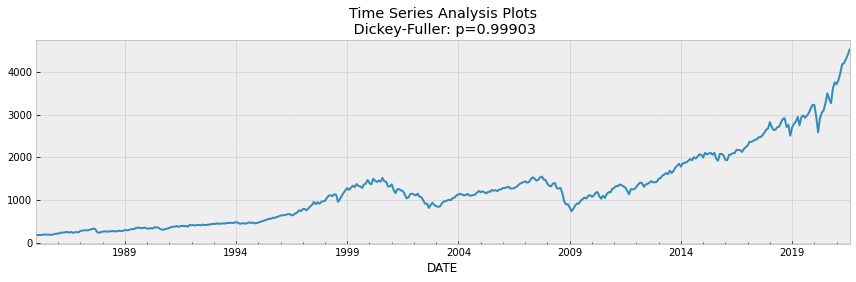

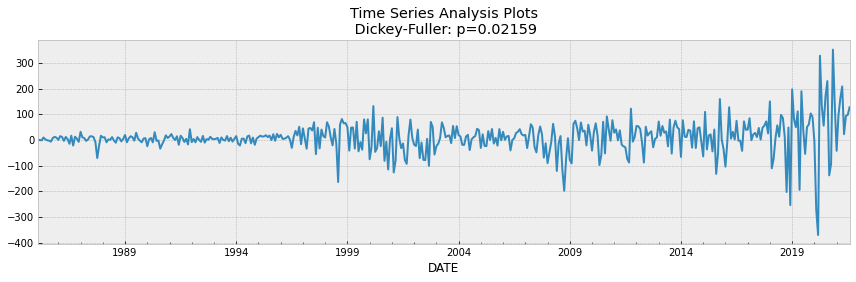

In [13]:
def tsplot(y, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,1)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))

        plt.tight_layout()
        
tsplot(df['SP500'])

data_diff = df['SP500'] - df['SP500'].shift(1)

tsplot(data_diff[1:])

````{margin}
方差扩大因子(variance inflation factor)简称VIF，是表征自变数观察值之间复共线性程度的数值。
````

如果我们在Dickey Fuller Test的假设中取5%作为置信水平，我们可以看到值远大于0.05，因此可以判断SP500是不具备平稳性的。

为了使数据保持平稳，有必要创建一个新的因变量，该因变量是根据当前每月价格减去上个月的价格计算得出的。在这种情况下，重新计算前面提到的测试，并且发现数据是平稳的，因为p-value显示为0。

下一步是找出自变量是否彼此不相关。为此选择了 VIF（Variance Inflating factor, 方差膨胀因子）测试。方差膨胀因子 （VIF） 用于检验回归模型中是否存在多重共线性。

In [14]:
df.columns

Index(['SP500', 'PERMIT', 'INDPRO', 'FEDFUNDS', 'PSAVERT', 'CURRCIR', 'MPRIME',
       'BUSLOANS', 'INTDSRUSM193N', 'DAUTOSAAR', 'CPIAUCSL', 'UNEMPLOY',
       'PMSAVE'],
      dtype='object')

In [15]:
# the independent variables set
X = df[['INTDSRUSM193N', 'BUSLOANS', 'MPRIME', 'FEDFUNDS', 'CURRCIR',
       'PSAVERT', 'PMSAVE', 'DAUTOSAAR', 'UNEMPLOY', 'INDPRO', 'PERMIT',
       'CPIAUCSL']]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

          feature          VIF
0   INTDSRUSM193N    97.796219
1        BUSLOANS   182.967472
2          MPRIME   694.827208
3        FEDFUNDS   327.213964
4         CURRCIR   365.219235
5         PSAVERT    91.198794
6          PMSAVE    40.048740
7       DAUTOSAAR    63.977266
8        UNEMPLOY    62.133967
9          INDPRO  1337.341806
10         PERMIT    37.411240
11       CPIAUCSL  3058.034391


从上述表中可以看出，每个变量的 VIF 测试值远高于 10。在这种情况下，具有最高 VIF 值的指标将被删除，并重新计算整个集合。只要值小于 10 的所有变量都保留下来。

In [16]:
# the independent variables set
X = df[[  'FEDFUNDS', 'CURRCIR','PSAVERT', 'PERMIT',]]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

    feature        VIF
0  FEDFUNDS   6.149062
1   CURRCIR   7.253224
2   PSAVERT   7.123685
3    PERMIT  10.382944


我们发现其中 11 个经济指标不符合线性回归规则。

我们这阶段最后一步就是将这 3 个指标与SP500价格指数整合在一起，并根据z score标准对其进行标准化。


In [17]:
df_new = df[['SP500','FEDFUNDS','CURRCIR','PSAVERT','PERMIT']]

In [18]:
df_z_scaled = df_new.copy()
  
# apply normalization techniques
for column in df_z_scaled.columns:
    df_z_scaled[column] = (df_z_scaled[column] -
                           df_z_scaled[column].mean()) / df_z_scaled[column].std()    
  
# view normalized data   
df_z_scaled.head()

,SP500,FEDFUNDS,CURRCIR,PSAVERT,PERMIT
DATE,,,,,
1985-01-01,-1.207185,1.749872,-1.190784,1.118462,0.751727
1985-02-01,-1.205417,1.803265,-1.195481,0.702642,0.756793
1985-03-01,-1.206010,1.831741,-1.193934,0.564035,0.921442
1985-04-01,-1.206957,1.721396,-1.190398,0.979855,0.761859
1985-05-01,-1.195873,1.614611,-1.187274,1.395675,0.875847


## 五、建模
现在，让我们继续在数据集上构建和评估机器学习模型。我们将首先为模型创建 `features` 和 `labels`，并将它们拆分为训练和测试示例。测试大小已保留为总数据集大小的 20%。

In [19]:
features = df_z_scaled.drop(columns = ['SP500'], axis = 1)
labels = df_z_scaled[['SP500']]

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 0)

In [20]:
print(f"Shape of training data: {X_train.shape}")
print(f"Shape of the training target data: {y_train.shape}")

print(f"Shape of test data: {X_test.shape}")
print(f"Shape of the test target data: {y_test.shape}")

Shape of training data: (352, 4)
Shape of the training target data: (352, 1)
Shape of test data: (88, 4)
Shape of the test target data: (88, 1)


### （1）Linear Regression

In [21]:
regr = LinearRegression()
  
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

0.9543343215374887


In [22]:
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(regr.coef_))], axis = 1)
coefficients

,0,0
0,FEDFUNDS,0.182386
1,CURRCIR,1.119148
2,PSAVERT,-0.027447
3,PERMIT,0.118363


`CURRCIR (Currency in Circulation)`具有最高的系数，这意味着对模型的影响最大。

在模型适合我们的训练数据后，我们可以继续预测我们的测试集，以评估模型性能。让我们将预测存储在`predicted`中。

评估指标：
1. 决定系数 （R^2）。这是数据中模型置信度的最重要指标，在回归模型的所有描述中都是必需的。
2. 均方误差 （MSE）。此值测量实际值和预测值之间的均方根误差。



In [23]:
y_pred = regr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

r2 = r2_score(y_test, y_pred)
print('r2 score for Random Forest model is', r2)

MSE:  0.048140955259271395
RMSE:  0.024070477629635698
r2 score for Random Forest model is 0.9543343215374887


### （2）RandomForest Regression

下面使用了随机森林回归的方法，因为`Random forest regression` 考虑了多种预测结果，所以基于随机森林的预测更准确、算法更稳定。

In [24]:
rfr = RandomForestRegressor()

rfr.fit(X_train, y_train)

score = rfr.score(X_train, y_train)
print("R-squared:", score)

R-squared: 0.9988945870353322


In [25]:
ypred = rfr.predict(X_test)

mse = mean_squared_error(y_test, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

r2 = r2_score(y_test, ypred)
print('r2 score for Random Forest model is', r2)

MSE:  0.00568486950353933
RMSE:  0.002842434751769665
r2 score for Random Forest model is 0.9946074310023176


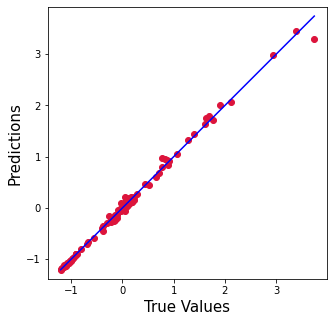

In [26]:
plt.figure(figsize=(5,5))
plt.scatter(y_test['SP500'].values, ypred, c='crimson')


p1 = max(max(ypred), max(y_test['SP500'].values))
p2 = min(min(ypred), min(y_test['SP500'].values))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

根据两种回归方法得出的 R2 和 MSE/RMSE，随机森林模型在这例子中显然较优， 其统计线性回归模型中提高了 6%，错误率降低了 20 倍。

## 【数据获取过程】

In [ ]:
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override() 

# download dataframe
data = pdr.get_data_yahoo("^GSPC", start="1985-01-01", end="2022-06-01", interval = "1mo")
data = data.rename(columns={'Close':'SP500'})
data.index.names=['DATE']
data = data[['SP500']]

data.to_csv('../data/sp500.csv')

In [ ]:
import pandas as pd
import os
import glob

PATH_DIR = '../data'
file_paths = sorted(glob.iglob(PATH_DIR + '/*'), key=os.path.getmtime)

df_merge=pd.read_csv(PATH_DIR+'/sp500.csv')
df_merge = df_merge.set_index('DATE')

for fp in file_paths:
    if 'sp500' not in fp:       
        df = pd.read_csv(fp)
        df = df.set_index('DATE')
        df_merge = df_merge.join(df, how='inner')
df_merge.to_csv('../us_economic_data.csv')